In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator, FuncFormatter
import datetime
import gzip

In [2]:
%matplotlib inline
plt.rcParams["axes.labelsize"] = 30
sns.set(font_scale=1.8)

In [3]:
df = pd.read_csv("./static/data/globalterrorismdb_0617dist.csv", encoding='ISO-8859-1')

/home/yedthon/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (4,6,31,33,53,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df.columns.values

array(['eventid', 'iyear', 'imonth', 'iday', 'approxdate', 'extended',
       'resolution', 'country', 'country_txt', 'region', 'region_txt',
       'provstate', 'city', 'latitude', 'longitude', 'specificity',
       'vicinity', 'location', 'summary', 'crit1', 'crit2', 'crit3',
       'doubtterr', 'alternative', 'alternative_txt', 'multiple',
       'success', 'suicide', 'attacktype1', 'attacktype1_txt',
       'attacktype2', 'attacktype2_txt', 'attacktype3', 'attacktype3_txt',
       'targtype1', 'targtype1_txt', 'targsubtype1', 'targsubtype1_txt',
       'corp1', 'target1', 'natlty1', 'natlty1_txt', 'targtype2',
       'targtype2_txt', 'targsubtype2', 'targsubtype2_txt', 'corp2',
       'target2', 'natlty2', 'natlty2_txt', 'targtype3', 'targtype3_txt',
       'targsubtype3', 'targsubtype3_txt', 'corp3', 'target3', 'natlty3',
       'natlty3_txt', 'gname', 'gsubname', 'gname2', 'gsubname2', 'gname3',
       'gsubname3', 'motive', 'guncertain1', 'guncertain2', 'guncertain3',
       'in

In [5]:
df.shape

(170350, 135)

In [6]:
dfs = df[["eventid", "iyear", "imonth", "iday",
          "country_txt", "city", "latitude","longitude",
          "success", "suicide", "attacktype1_txt", "targtype1_txt", "weaptype1_txt",
          "gname", "motive", "summary", "nkill", "nwound"]]

In [7]:
dfs = dfs.rename(
    columns={"eventid": "id", 'iyear':'year', 'imonth':'month', 'iday':'day', 'country_txt':'country',
             'attacktype1_txt':'attacktype', 'targtype1_txt':'target', 'weaptype1_txt':'weapon',
             'gname': 'group', 'nkill':'fatalities', 'nwound':'injuries'})
dfs['fatalities'] = dfs['fatalities'].fillna(0).astype(int)
dfs['injuries'] = dfs['injuries'].fillna(0).astype(int)

In [8]:
dfs['country'].replace('United States', 'United States of America',inplace=True)

dfs['country'].replace('Bosnia-Herzegovina', 'Bosnia and Herzegovina',inplace=True)

dfs['country'].replace('Slovak Republic', 'Slovakia',inplace=True)

In [9]:
len(set(dfs["country"]))

205

In [10]:
len(dfs[dfs["fatalities"] != 0]) / len(dfs)

0.4563721749339595

In [11]:
len(dfs[dfs["injuries"] != 0]) / len(dfs)

0.33955385970061636

In [12]:
len(dfs[(dfs["injuries"] != 0) | (dfs["fatalities"] != 0)]) / len(dfs)

0.5911006750807162

In [13]:
dfs['fatalities'].sum()

383554

In [14]:
dfs['injuries'].sum()

496117

In [15]:
dfs_map = dfs[['id', 'year', 'latitude', 'longitude',
               'attacktype', 'target', 'summary', 'fatalities', 'injuries']]

dfs_map = dfs_map.rename(columns={'latitude': 'lat', 'longitude': 'lon', 'attachtype': 'attack'})

In [16]:
dfs_map['intensity'] = dfs_map['fatalities'] + dfs_map['injuries'] + 1

dfs_map['id'] = dfs_map.index

In [17]:
dfs_map = dfs_map[dfs_map["lat"].notnull() & dfs_map["lon"].notnull()]

dfs_map = dfs_map[(dfs_map["lon"] >= -180) & (dfs_map["lon"] <= 180) & (dfs_map["lat"] >= -90) & (dfs_map["lat"] <= 90)]

In [18]:
len(dfs_map)

165744

In [19]:
dfs_map.to_json("./static/data/global_terrorism_map.json", orient='records')

In [20]:
dfs_map['intensity'].max()

8750

In [21]:
def freq_table(df, column):
    frequency_table = pd.crosstab(index=df[column],
                columns="count").sort_values("count", ascending=False)
    return frequency_table

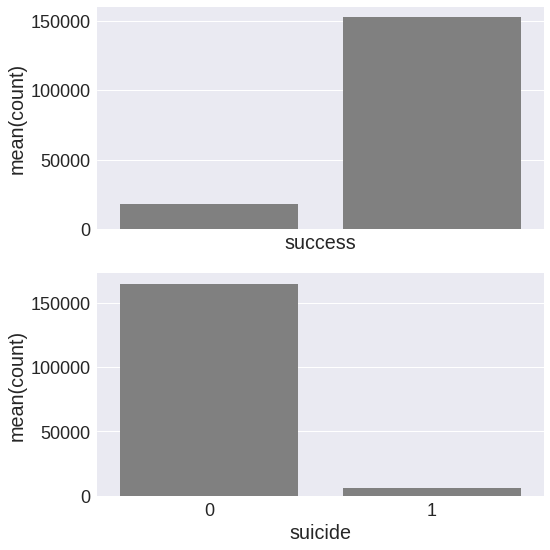

In [22]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 9),  sharex=True)
n = 0
for i in ["success", "suicide"]:      
    n += 1
    ax =  locals().get('ax' + str(n))
    frequency_table = freq_table(dfs, i)
#     if "Unknown" in frequency_table.index:
#         frequency_table = frequency_table.drop("Unknown") .iloc[:20]
#     else:
#         frequency_table = frequency_table.iloc[:20]
    
    sns.barplot(y="count", x=frequency_table.index, data=frequency_table, color="grey", ax=ax)

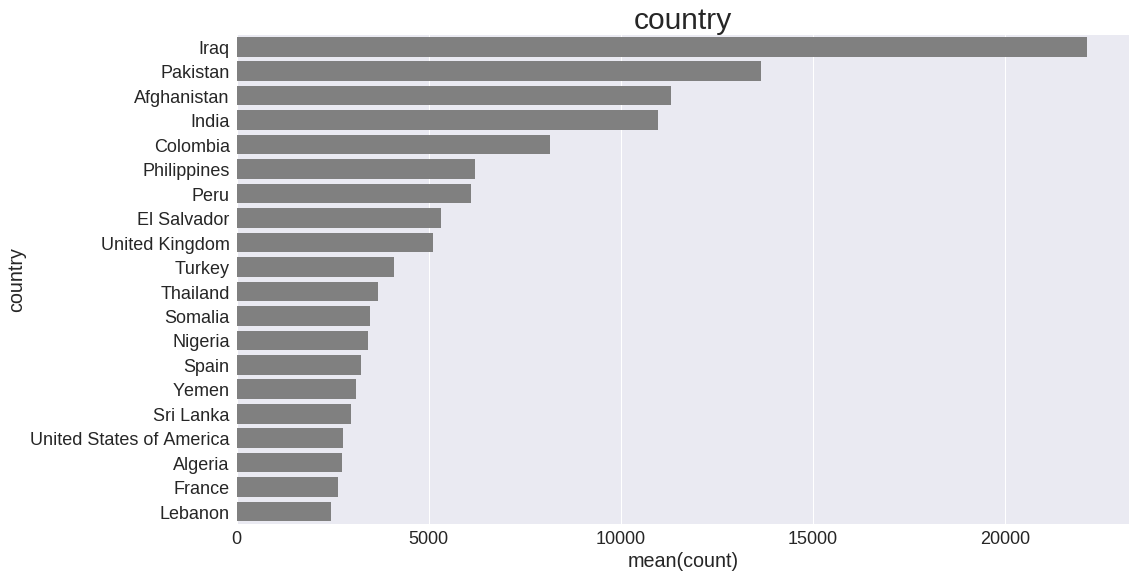

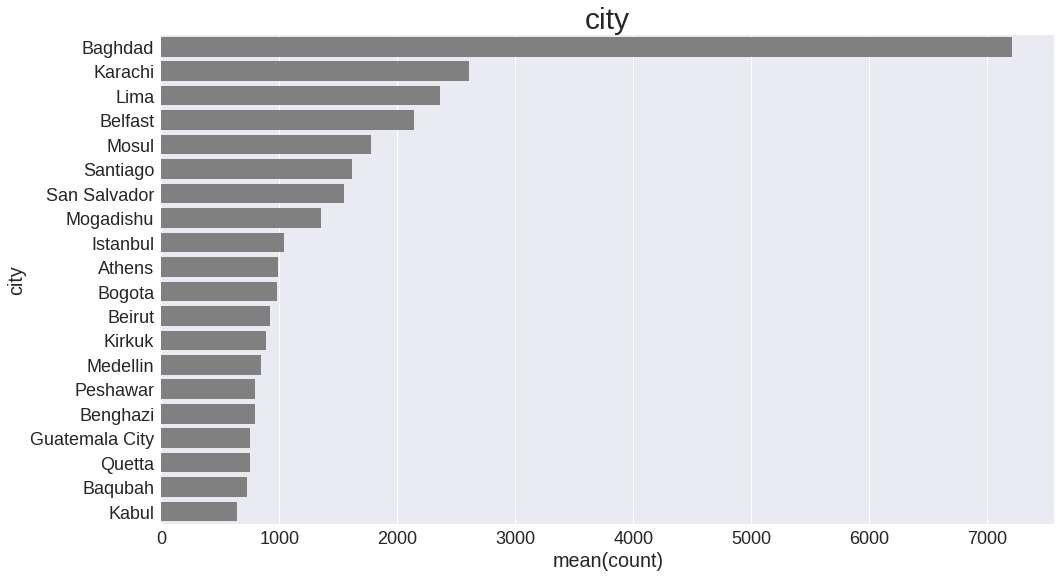

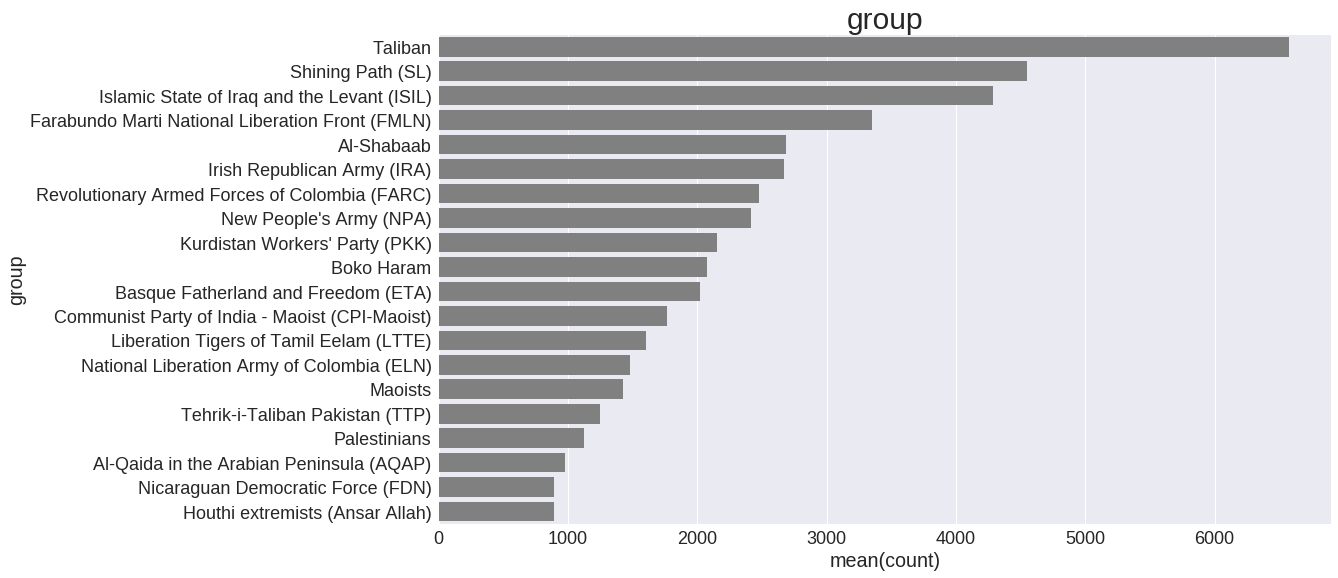

In [23]:
# fig, (ax1, ax2, ax3) = plt.subplots(figsize=(16, 9), nrows=3)
for i in ["country", "city", "group"]:    
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.set_title(i, fontsize= 30)
    frequency_table = freq_table(dfs, i)
    if "Unknown" in frequency_table.index:
        frequency_table = frequency_table.drop("Unknown") .iloc[:20]
    else:
        frequency_table = frequency_table.iloc[:20]
    
    sns.barplot(y=frequency_table.index, x="count", data=frequency_table, orient="h", color="grey")

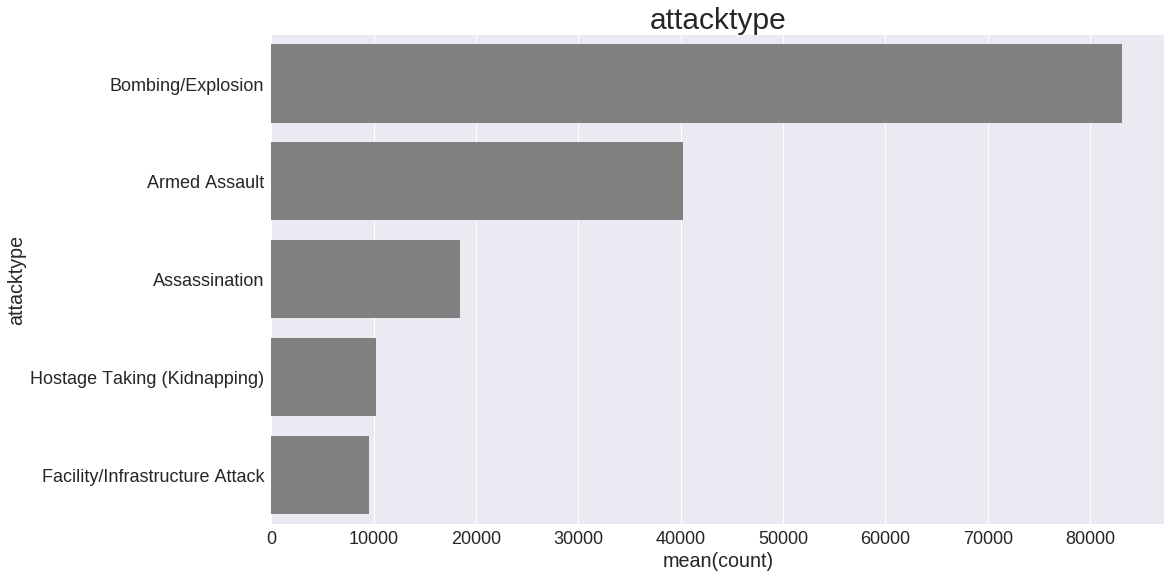

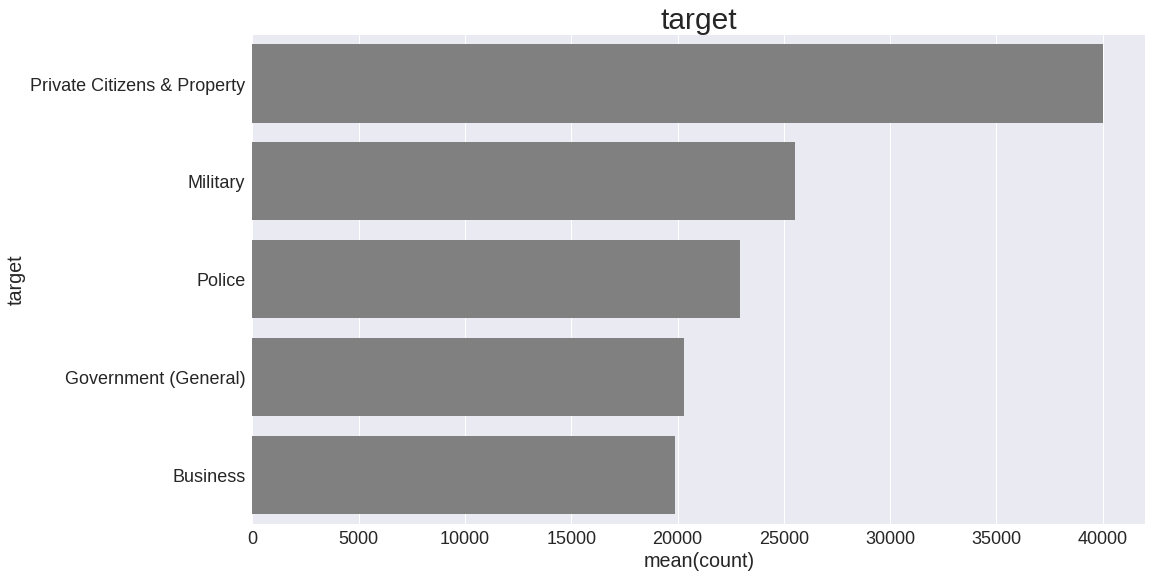

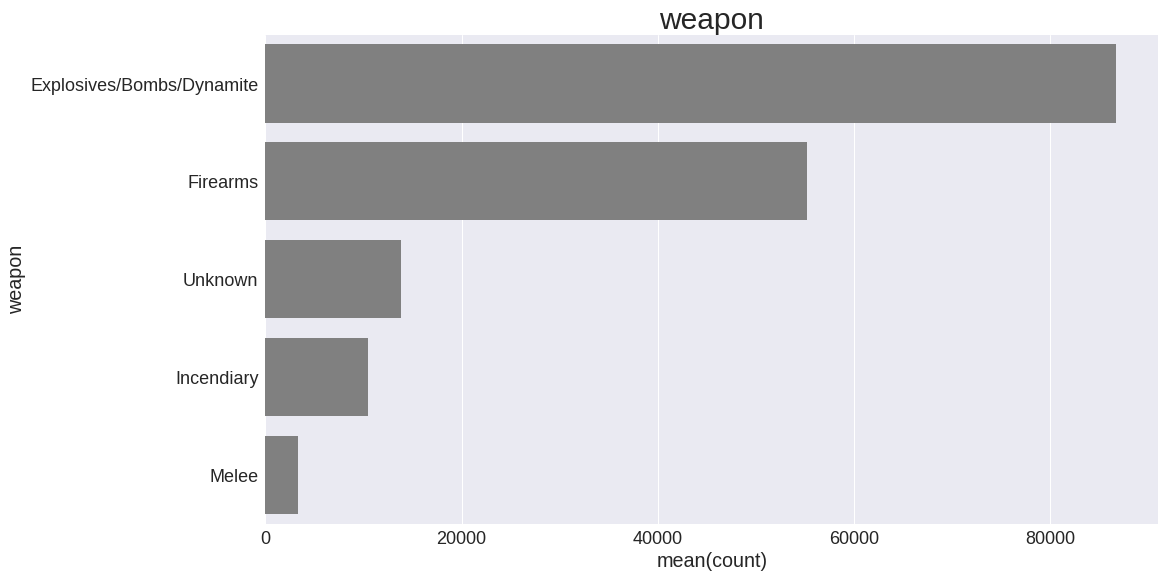

In [24]:
# fig, (ax1, ax2, ax3) = plt.subplots(figsize=(16, 9), nrows=3)
for i in ["attacktype", "target", "weapon"]:    
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.set_title(i, fontsize= 30)
    frequency_table = freq_table(dfs, i)
    frequency_table = frequency_table.iloc[:5]
    
    sns.barplot(y=frequency_table.index, x="count", data=frequency_table, orient="h", color="grey")

In [25]:
dfs_time = dfs.copy()

dfs_time = dfs_time[(dfs_time["month"] >=1) & (dfs_time["month"] <= 12) & (dfs_time["day"] >=1) & (dfs_time["day"] <= 31)]

dfs_time["date"] = pd.to_datetime(dfs_time[["year", "month", "day"]])

In [26]:
dfs_time

,id,year,month,day,country,city,latitude,longitude,success,suicide,attacktype,target,weapon,group,motive,summary,fatalities,injuries,date
0,197000000001,1970,7,2,Dominican Republic,Santo Domingo,18.456792,-69.951164,1,0,Assassination,Private Citizens & Property,Unknown,MANO-D,NaN,NaN,1,0,1970-07-02
5,197001010002,1970,1,1,United States of America,Cairo,37.005105,-89.176269,1,0,Armed Assault,Police,Firearms,Black Nationalists,To protest the Cairo Illinois Police Deparment,1/1/1970: Unknown African American assailants ...,0,0,1970-01-01
6,197001020001,1970,1,2,Uruguay,Montevideo,-34.891151,-56.187214,0,0,Assassination,Police,Firearms,Tupamaros (Uruguay),NaN,NaN,0,0,1970-01-02
7,197001020002,1970,1,2,United States of America,Oakland,37.805065,-122.273024,1,0,Bombing/Explosion,Utilities,Explosives/Bombs/Dynamite,Unknown,NaN,1/2/1970: Unknown perpetrators detonated explo...,0,0,1970-01-02
8,197001020003,1970,1,2,United States of America,Madison,43.076592,-89.412488,1,0,Facility/Infrastructure Attack,Military,Incendiary,New Year's Gang,To protest the War in Vietnam and the draft,"1/2/1970: Karl Armstrong, a member of the New ...",0,0,1970-01-02
9,197001030001,1970,1,3,United States of America,Madison,43.072950,-89.386694,1,0,Facility/Infrastructure Attack,Government (General),Incendiary,New Year's Gang,To protest the War in Vietnam and the draft,"1/3/1970: Karl Armstrong, a member of the New ...",0,0,1970-01-03
10,197001050001,1970,1,1,United States of America,Baraboo,43.468500,-89.744299,0,0,Bombing/Explosion,Military,Explosives/Bombs/Dynamite,"Weather Underground, Weathermen",NaN,NaN,0,0,1970-01-01
11,197001060001,1970,1,6,United States of America,Denver,39.740010,-104.992259,1,0,Facility/Infrastructure Attack,Military,Incendiary,Left-Wing Militants,Protest the draft and Vietnam War,1/6/1970: Unknown perpetrators threw a Molotov...,0,0,1970-01-06
12,197001080001,1970,1,8,Italy,Rome,41.890520,12.494249,1,0,Hijacking,Airports & Aircraft,Firearms,Unknown,NaN,NaN,0,0,1970-01-08
13,197001090001,1970,1,9,United States of America,Detroit,42.331685,-83.047924,1,0,Facility/Infrastructure Attack,Government (General),Incendiary,Left-Wing Militants,NaN,1/9/1970: Unknown perpetrators set off a fireb...,0,0,1970-01-09


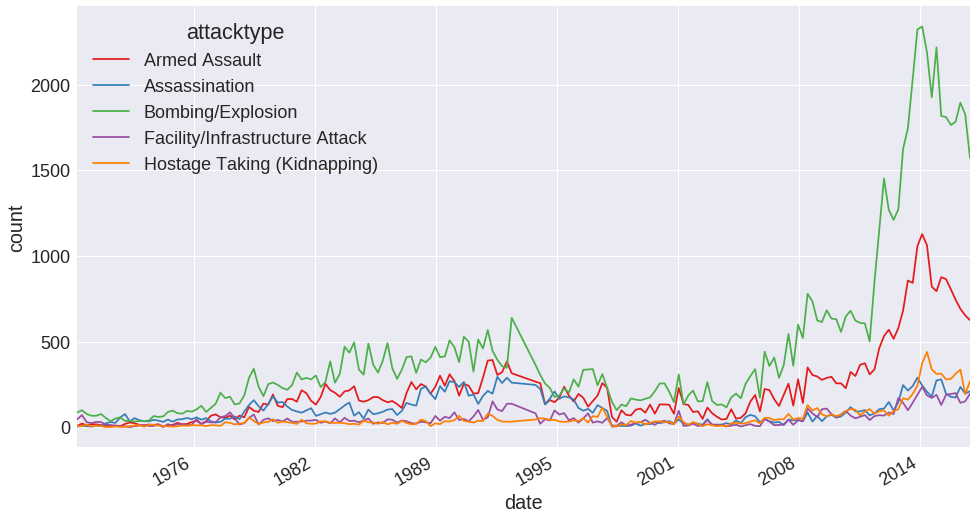

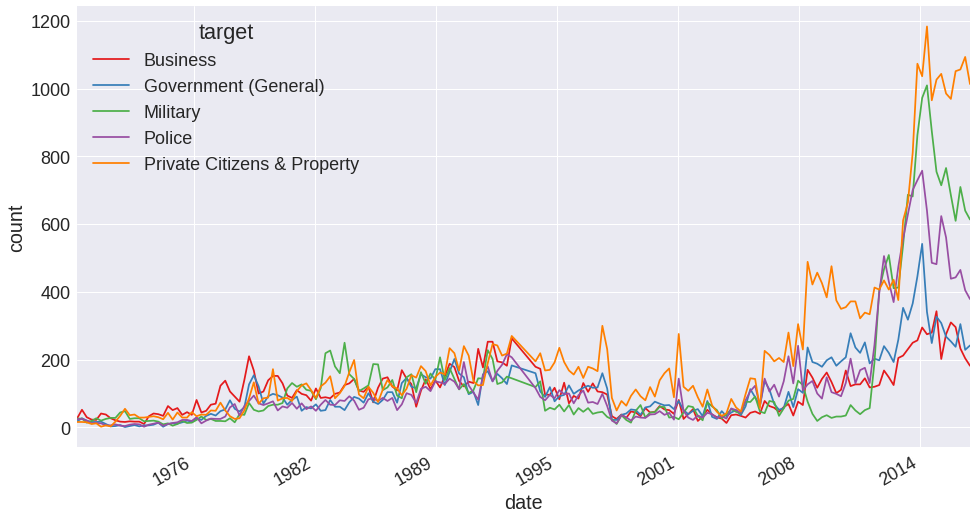

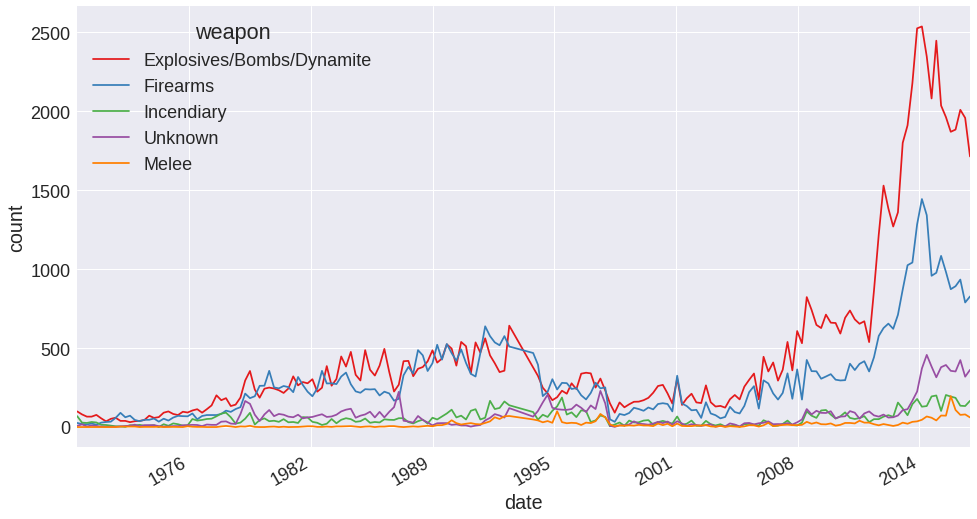

In [27]:
for i in ["attacktype", "target", "weapon"]:
    top = freq_table(dfs, i)[:5].index.values
    dfs_ts= dfs_time[dfs_time[i].isin(top)]
    dfs_ts = dfs_ts.groupby(["date", i])[i].count()
    dfs_ts = dfs_ts.reset_index(level=1, name="count")
    dfs_ts = dfs_ts.groupby([pd.TimeGrouper(freq='Q'), i])["count"].sum()
    dfs_ts = dfs_ts.reset_index()
    fig, ax = plt.subplots(figsize=(16, 9))
    # assign locator and formatter for the xaxis ticks.
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: pd.to_datetime(x).year))
    # ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m.%d'))
    fig.autofmt_xdate()
    sns.tsplot(dfs_ts,
               time="date", value="count", unit=i, condition=i,
              color=sns.color_palette("Set1"))

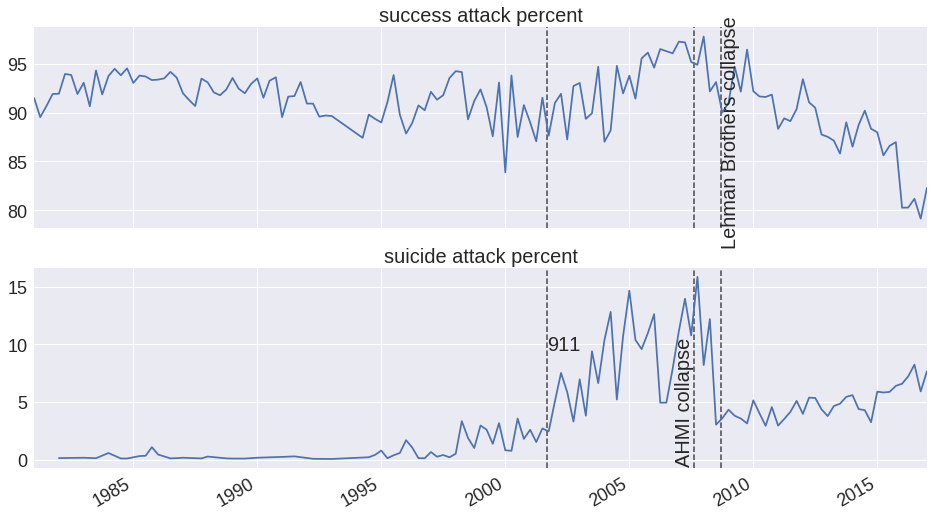

In [28]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 9), sharex=True)
n = 0
for i in ["success", "suicide"]:      
    n += 1
    ax =  locals().get('ax' + str(n))
    
    dfs_ts = dfs_time.groupby(["date", i])[i].count()
    dfs_ts = dfs_ts.reset_index(level=1, name="count")
    dfs_ts = dfs_ts.groupby([pd.TimeGrouper(freq='Q'), i])["count"].sum()
    dfs_ts = dfs_ts.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
    
    dfs_ts = dfs_ts.reset_index()
    dfs_ts = dfs_ts[dfs_ts[i] == 1]
    
    ax.xaxis.set_major_locator(mdates.YearLocator(5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_minor_locator(AutoMinorLocator())

    datemin = datetime.date(dfs_ts.date.min().year, 1, 1)
    datemax = datetime.date(dfs_ts.date.max().year + 1, 1, 1)
    ax.set_xlim(datemin, datemax)  
    ax.axvline("2001-09-11", color="black", linestyle="dashed", alpha=0.6)
    ax.axvline("2007-08-06", color="black", linestyle="dashed", alpha=0.6)
    ax.axvline("2008-09-15", color="black", linestyle="dashed", alpha=0.6)

    if n == 1:
        ax.text("2008-09-15", 88, "Lehman Brothers collapse",
                verticalalignment='center',
                rotation=90, size=20)        
    if n == 2:        
        ax.text("2001-09-11", 10, "911", verticalalignment='center', size=20)
        ax.text("2007-08-06", 5, "AHMI collapse",
                verticalalignment='center', horizontalalignment='right',
                rotation=90, size=20)

    
    ax.plot(dfs_ts["date"], dfs_ts["count"])
    
#     sns.tsplot(dfs_ts,
#            time="date", value="count", unit=i, condition=i,
#           color=sns.color_palette("Set2"), ax=ax)
#     ax.legend_.remove()    
    
    ax.set_title(i + " attack percent", size=20)

    fig.autofmt_xdate()

In [29]:
dfs_period_casualties = dfs_time.groupby(["date"])["fatalities", "injuries"].sum()

dfs_period_casualties = dfs_period_casualties.groupby(pd.TimeGrouper(freq='M'))["fatalities", "injuries"].sum()

dfs_period_casualties = dfs_period_casualties.reset_index()

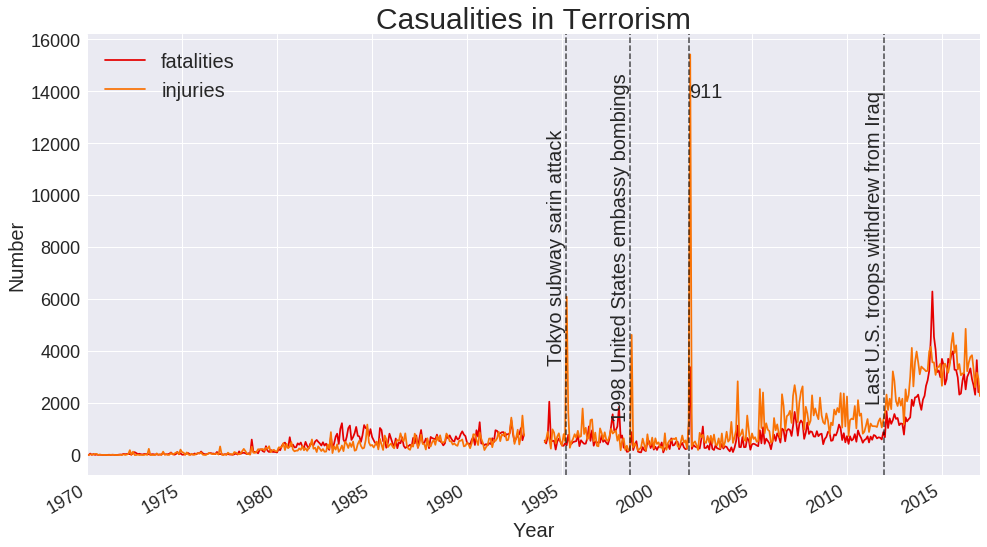

In [30]:
fig, ax = plt.subplots(figsize=(16, 9))
# ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.plot(dfs_period_casualties["date"], dfs_period_casualties["fatalities"], color='xkcd:red')
ax.plot(dfs_period_casualties["date"], dfs_period_casualties["injuries"], color='xkcd:orange')
ax.xaxis.set_major_locator(mdates.YearLocator(5))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m.%d'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(AutoMinorLocator())
datemin = datetime.date(dfs_period_casualties.date.min().year, 1, 1)
datemax = datetime.date(dfs_period_casualties.date.max().year + 1, 1, 1)
ax.set_xlim(datemin, datemax)
fig.autofmt_xdate()

ax.legend(prop={'size': 20})

plt.axvline(x="2001-09-11", color="black", linestyle="dashed", alpha=0.6)
plt.text("2001-09-11", 14000, "911", verticalalignment='center', size=20)

plt.axvline(x="1995-03-20", color="black", linestyle="dashed", alpha=0.6)
plt.text("1995-03-20", 8000, "Tokyo subway sarin attack", rotation=90,
         verticalalignment='center', horizontalalignment='right', size=20)

plt.axvline(x="1998-08-07", color="black", linestyle="dashed", alpha=0.6)
plt.text("1998-08-07", 8000, "1998 United States embassy bombings",
         horizontalalignment='right', verticalalignment='center',
        rotation=90, size=20)

plt.axvline(x="2011-12-18", color="black", linestyle="dashed", alpha=0.6)
plt.text("2011-12-18", 8000, "Last U.S. troops withdrew from Iraq",
         horizontalalignment='right', verticalalignment='center',
        rotation=90, size=20)

plt.xlabel('Year', size=20)
plt.ylabel('Number', size=20)
plt.title('Casualities in Terrorism', size=30)